# Applied Process Mining Module

This notebook is part of an Applied Process Mining module. The collection of notebooks is a *living document* and subject to change. 

# Lecture 4 - 'Predictive Process Mining' (Python / PM4Py)

## Setup

<img src="https://pm4py.fit.fraunhofer.de/static/assets/images/pm4py-site-logo-padded.png" alt="PM4Py" style="width: 200px;"/>

In this notebook, we are using the [PM4Py library](https://pm4py.fit.fraunhofer.de/) in combination with several standard Python data science libraries:

* [pandas](https://pandas.pydata.org/)
* [PyTorch](https://pytorch.org/)

In [55]:
## Perform the commented out commands to install the dependencies
# %pip install pandas
# %pip install matplotlib
# %pip install pm4py
# %pip install torch
# %pip install tqdm

In [56]:
import numpy as np
import pandas as pd
import pm4py
import os
import torch
import torch.nn as nn
from tqdm.autonotebook import tqdm

# Predictive Process Mining

## Event Log 

We are using the Sepsis event log as an example.

In [57]:
sepsis = pd.read_csv("../data/sepsis.csv", sep=';')
sepsis_log = pm4py.format_dataframe(sepsis, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
sepsis_log = pm4py.convert_to_event_log(sepsis_log)

In [58]:
len(sepsis_log)

1050

## Feature Extraction / Encoding

We are using the PM4Py functionality to do [feature selection and processing](https://pm4py.fit.fraunhofer.de/documentation/1.5#item-7-0-1) of the event log.

### Set of Events

In [59]:
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
from pm4py.objects.log.util.log import project_traces

data, feature_names = log_to_features.apply(sepsis_log, parameters={"str_ev_attr": ["concept:name"]})

The standard encoding of the `concept:name` attribute (i.e., the event label) is a one-hot encoded vector.

In [60]:
print("1st trace : " + str(project_traces(sepsis_log)[0]))

1st trace : ['ER Registration', 'Leucocytes', 'CRP', 'LacticAcid', 'ER Triage', 'ER Sepsis Triage', 'IV Liquid', 'IV Antibiotics', 'Admission NC', 'CRP', 'Leucocytes', 'Leucocytes', 'CRP', 'Leucocytes', 'CRP', 'CRP', 'Leucocytes', 'Leucocytes', 'CRP', 'CRP', 'Leucocytes', 'Release A']


In [61]:
print("1st trace encoded: " + str(data[0]))

1st trace encoded: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


The index of the number corresponds to the index in the following feature label vector:

In [62]:
feature_names

['event:concept:name@Admission IC',
 'event:concept:name@Admission NC',
 'event:concept:name@CRP',
 'event:concept:name@ER Registration',
 'event:concept:name@ER Sepsis Triage',
 'event:concept:name@ER Triage',
 'event:concept:name@IV Antibiotics',
 'event:concept:name@IV Liquid',
 'event:concept:name@LacticAcid',
 'event:concept:name@Leucocytes',
 'event:concept:name@Release A',
 'event:concept:name@Release B',
 'event:concept:name@Release C',
 'event:concept:name@Release D',
 'event:concept:name@Release E',
 'event:concept:name@Return ER']

Let us try again for a different trace:

In [63]:
print("2nd trace : " + str(project_traces(sepsis_log)[1]))
print("2nd trace encoded: " + str(data[1]))

2nd trace : ['ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'LacticAcid', 'CRP', 'IV Liquid', 'IV Antibiotics']
2nd trace encoded: [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]


The overall data shape is:

In [64]:
np.asarray(data).shape

(1050, 16)

So, PM4Py gives us a *one-hot encoding* of the so called *set abstraction* of the event log. This means there are 16 distinct activities in the event log and the feature vector simply encodes whether that activity is present or not in the data. 

Let us have a look at the distribution of these feature vectors:

In [65]:
dist_features = np.unique(data, return_counts= True, axis = 0)
dist_features

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 1]]),
 array([ 35,   2,  63,  23,   3,   8,   7,  99,   2,   3,   1,   1,   1,
          2,   2,   2,   2,  28,  11,   2,   1,   1,   2,   6,  14,  13,
          4,   1,   1,   2,   1,   3,  23,  16,   3,  10,   5,  21,   1,
          9,   5,  14,   5,  29, 267, 186,   1,   1,   3,   4,   1,   1,
          1,   2,   4,   8,   1,   1,   1,   2,   3,   1,   6,  31,  38],
       dtype=int64))

What is the most common feature vector?

In [66]:
dist_features[0][np.argmax(dist_features[1])]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

Makes sense, almost all activities actually are bound to occur in this process. There are only few choices.
So, this encoding is likely not the most useful one but a very simple one.

### 2-grams

In [67]:
data_2gram, feature_names = log_to_features.apply(sepsis_log, parameters={"str_ev_attr": None, 
                                                        "str_tr_attr": None, 
                                                        "num_ev_attr": None, 
                                                        "num_tr_attr": None, 
                                                        "str_evsucc_attr": ["concept:name"]})

There is a bug in PM4Py (https://github.com/pm4py/pm4py-core/issues/293) that causes too many feature to be returned.
So, we need to disregard the initial features extracted.

In [68]:
feature_names = feature_names[41:]
len(feature_names)

115

In [69]:
feature_names

['succession:concept:name@Admission IC#Admission IC',
 'succession:concept:name@Admission IC#Admission NC',
 'succession:concept:name@Admission IC#CRP',
 'succession:concept:name@Admission IC#ER Sepsis Triage',
 'succession:concept:name@Admission IC#LacticAcid',
 'succession:concept:name@Admission IC#Leucocytes',
 'succession:concept:name@Admission NC#Admission IC',
 'succession:concept:name@Admission NC#Admission NC',
 'succession:concept:name@Admission NC#CRP',
 'succession:concept:name@Admission NC#ER Sepsis Triage',
 'succession:concept:name@Admission NC#ER Triage',
 'succession:concept:name@Admission NC#IV Antibiotics',
 'succession:concept:name@Admission NC#IV Liquid',
 'succession:concept:name@Admission NC#LacticAcid',
 'succession:concept:name@Admission NC#Leucocytes',
 'succession:concept:name@Admission NC#Release A',
 'succession:concept:name@Admission NC#Release B',
 'succession:concept:name@Admission NC#Release C',
 'succession:concept:name@Admission NC#Release D',
 'succes

In [70]:
data_2gram = np.asarray(data_2gram)[:,41:]

In [71]:
print("1st trace : " + str(project_traces(sepsis_log)[0]))

1st trace : ['ER Registration', 'Leucocytes', 'CRP', 'LacticAcid', 'ER Triage', 'ER Sepsis Triage', 'IV Liquid', 'IV Antibiotics', 'Admission NC', 'CRP', 'Leucocytes', 'Leucocytes', 'CRP', 'Leucocytes', 'CRP', 'CRP', 'Leucocytes', 'Leucocytes', 'CRP', 'CRP', 'Leucocytes', 'Release A']


In [72]:
print("1st trace encoded: " + str(data_2gram[0]))

1st trace encoded: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Bag of Words / Multiset

Another option would be to use the encoding known as `bag of words` in Natural Language Processing, which is constructing a multiset of the one-hot encoded events. So, the frequency with which each activity occurs is reflected.-

In [73]:
print(sepsis.loc[:,["case_id"]].nunique())

case_id    1049
dtype: int64


We seem to have a NA value in the case attribute let us fix this by replacing with a String (in real world data you should be looking for the underlying reason)

In [74]:
sepsis = sepsis.fillna("MISSING")

In [75]:
print(sepsis.loc[:,["case_id"]].nunique())

case_id    1050
dtype: int64


This looks better. Now lets build a bag of words representation by grouping our data and then counting the number of events refering to the individual activities.

In [76]:
sepsis_multiset_pd = sepsis.loc[:,["case_id", "activity"]].groupby(["case_id", "activity"]).size().unstack(fill_value=0)
sepsis_multiset_pd

activity,Admission IC,Admission NC,CRP,ER Registration,ER Sepsis Triage,ER Triage,IV Antibiotics,IV Liquid,LacticAcid,Leucocytes,Release A,Release B,Release C,Release D,Release E,Return ER
case_id,,,,,,,,,,,,,,,,
A,0,1,7,1,1,1,1,1,1,7,1,0,0,0,0,0
AA,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0
AAA,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1
AB,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0
ABA,0,1,4,1,1,1,1,1,1,5,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZV,0,1,2,1,1,1,1,1,1,2,1,0,0,0,0,0
ZW,0,2,2,1,1,1,1,1,1,2,1,0,0,0,0,0
ZX,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0


In [77]:
data_multiset = np.asarray(sepsis_multiset_pd)
data_multiset.shape

(1050, 16)

In [78]:
print("1st trace : " + str(project_traces(sepsis_log)[0]))
print("1st trace encoded: " + str(data_multiset[0]))

1st trace : ['ER Registration', 'Leucocytes', 'CRP', 'LacticAcid', 'ER Triage', 'ER Sepsis Triage', 'IV Liquid', 'IV Antibiotics', 'Admission NC', 'CRP', 'Leucocytes', 'Leucocytes', 'CRP', 'Leucocytes', 'CRP', 'CRP', 'Leucocytes', 'Leucocytes', 'CRP', 'CRP', 'Leucocytes', 'Release A']
1st trace encoded: [0 1 7 1 1 1 1 1 1 7 1 0 0 0 0 0]


In [79]:
print("2nd trace : " + str(project_traces(sepsis_log)[1]))
print("2nd trace encoded: " + str(data_multiset[1]))

2nd trace : ['ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'LacticAcid', 'CRP', 'IV Liquid', 'IV Antibiotics']
2nd trace encoded: [0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0]


This already gives us more information.

# Prediction

Let us try to build a basic prediction model based on this information.

### Throughput time

We aim to predict the throughput time of a case. So let us look at the distribution of throughput time.

In [80]:
from pm4py.statistics.traces.generic.log import case_statistics

durations = np.asarray(case_statistics.get_all_case_durations(sepsis_log, parameters={ case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"} ))
durations = np.expand_dims(durations, 1)
len(durations)
durations = durations / 60 / 60 / 24 # in days

Text(0, 0.5, 'Throughput time (days)')

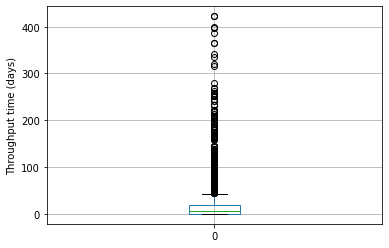

In [81]:
pd.DataFrame(durations).boxplot().set_ylabel('Throughput time (days)')

In [82]:
durations = durations.flatten()

In [83]:
durations

array([1.41203704e-03, 1.44675926e-03, 1.58564815e-03, ...,
       3.98923646e+02, 4.21865822e+02, 4.22323947e+02])

Remove outliers

In [84]:
min_duration = 0.5
max_duration = 100

data = np.asarray(data)[np.where((durations < max_duration) & (durations > min_duration))]
data_2gram = np.asarray(data_2gram)[np.where((durations < max_duration) & (durations > min_duration))]
data_multiset = data_multiset[np.where((durations < max_duration) & (durations > min_duration))]
durations = durations[np.where((durations < max_duration) & (durations > min_duration))]

Text(0, 0.5, 'Throughput time (days)')

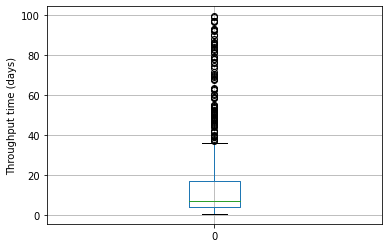

In [85]:
pd.DataFrame(durations).boxplot().set_ylabel('Throughput time (days)')

Choose the encoding:

In [91]:
data_input = data_2gram

Scale the data

In [92]:
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()
data_scaled = scaler_x.fit_transform(data_input)

scaler_y = MinMaxScaler()
durations_scaled = scaler_y.fit_transform(durations.reshape(-1, 1))

We make use of PyTorch to build a simple Neural Network.

In [93]:
from torch.utils.data import TensorDataset, DataLoader

# We need float32 data
x = torch.from_numpy(data_scaled.astype('float32'))
y = torch.from_numpy(durations_scaled.astype('float32'))

# Always check the shapes
print(x.shape)
print(y.shape)

ds = TensorDataset(x, y)
train_dataloader = DataLoader(ds, batch_size=32, shuffle=True)

torch.Size([698, 115])
torch.Size([698, 1])


Let us check a random single sample from our data loader (always a good idea!)

In [94]:
inputs, classes = next(iter(train_dataloader))
print(inputs[0])
print(classes[0])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])
tensor([0.0588])


Let's define a simple network and try to overfit:

In [95]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(            
            torch.nn.Linear(x.shape[1], 8),
            nn.BatchNorm1d(num_features=8),
            nn.LeakyReLU(),            
            torch.nn.Linear(8, 32),
            nn.BatchNorm1d(num_features=32),
            nn.LeakyReLU(),
            torch.nn.Linear(32, 64),
            nn.BatchNorm1d(num_features=64),
            nn.LeakyReLU(),
            torch.nn.Linear(64, 32),
            nn.BatchNorm1d(num_features=32),
            nn.LeakyReLU(),            
            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [96]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=115, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=8, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [97]:
def train(dataloader, model, loss_fn, measure_fn, optimizer, epochs, print_interval = 10):
    
    losses = []
    size = len(dataloader.dataset)
    
    for epoch in range(epochs):    
        
        loop = tqdm(dataloader)

        for batch, (X, y) in enumerate(loop):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()

            # Compute prediction error
            pred = model(X)
            
            loss = loss_fn(pred, y)
            measure = measure_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            
            losses.append([loss.item(), measure.item()])

            loop.set_description('Epoch {}/{}'.format(epoch + 1, epochs))
            loop.set_postfix(loss=loss.item(), measure=measure.item())
    
    return losses

In [98]:
loss_fn = nn.MSELoss()
measure_fn = nn.L1Loss() # MAE
optimizer = torch.optim.Adam(model.parameters())

results = train(train_dataloader, model, loss_fn, measure_fn, optimizer, 200)
print("Done!")

Epoch 200/200: 100%|██████████| 22/22 [00:00<00:00, 134.58it/s, loss=0.024, measure=0.113]

Done!


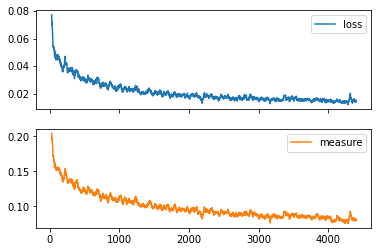

In [99]:
results_data = pd.DataFrame(results).rolling(window=32).mean()
results_data.columns = ['loss', 'measure']
ax = results_data.plot(subplots=True);

In [100]:
print("MAE: " + str(scaler_y.inverse_transform(np.asarray(results[len(results)-1][1]).reshape(-1, 1))))

data_mean = durations.mean()
print("Data mean: " + str(data_mean))
print("Data MAE for prediction simply the mean: " + str((np.absolute(durations - data_mean).mean())))

MAE: [[11.72235532]]
Data mean: 16.164402459407828
Data MAE for prediction simply the mean: 14.65345254227676


Now, extend this example with other encodings and a proper (!) evaluation for sequential event log data!